In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
df = pd.read_csv('C:/Users/Home/Downloads/breast-cancer.csv') 
print("Dataset loaded successfully.")

# Data Preparation 

# a. Drop the 'id' column as it's not useful for classification
# The 'Unnamed: 32' column is often an empty column in this dataset, so we drop it too.
if 'id' in df.columns:
    df = df.drop('id', axis=1)
if 'Unnamed: 32' in df.columns:
    df = df.drop('Unnamed: 32', axis=1)

# Convert the target variable ('diagnosis') to numerical format
# M (Malignant) = 1, B (Benign) = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Scale the features
# SVM is highly sensitive to the scale of the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
# We use a standard 80/20 split.
# stratify=y ensures both splits have the same proportion of Malignant/Benign cases.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Data Summary ---")
print(f"Total number of samples: {len(df)}")
print(f"Number of features: {X.shape[1]}")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Target variable distribution in training set:\n{y_train.value_counts(normalize=True)}")

Dataset loaded successfully.

--- Data Summary ---
Total number of samples: 569
Number of features: 30
Training set size: (455, 30)
Testing set size: (114, 30)
Target variable distribution in training set:
diagnosis
0    0.626374
1    0.373626
Name: proportion, dtype: float64


In [2]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- Training the Models ---

# 1. Linear Kernel SVM
# A linear kernel (kernel='linear') is great for linearly separable data.
linear_svc = SVC(kernel='linear', random_state=42)
linear_svc.fit(X_train, y_train)

# 2. Radial Basis Function (RBF) Kernel SVM
# The RBF kernel (kernel='rbf') is the default and is used for non-linear decision boundaries.
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train, y_train)

# --- Evaluation on the Test Set ---

# Predict on the test set for both models
y_pred_linear = linear_svc.predict(X_test)
y_pred_rbf = rbf_svc.predict(X_test)

print("--- Linear Kernel SVM Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")
print(classification_report(y_test, y_pred_linear))

print("\n--- RBF Kernel SVM Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
print(classification_report(y_test, y_pred_rbf))

--- Linear Kernel SVM Performance ---
Accuracy: 0.9649
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


--- RBF Kernel SVM Performance ---
Accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



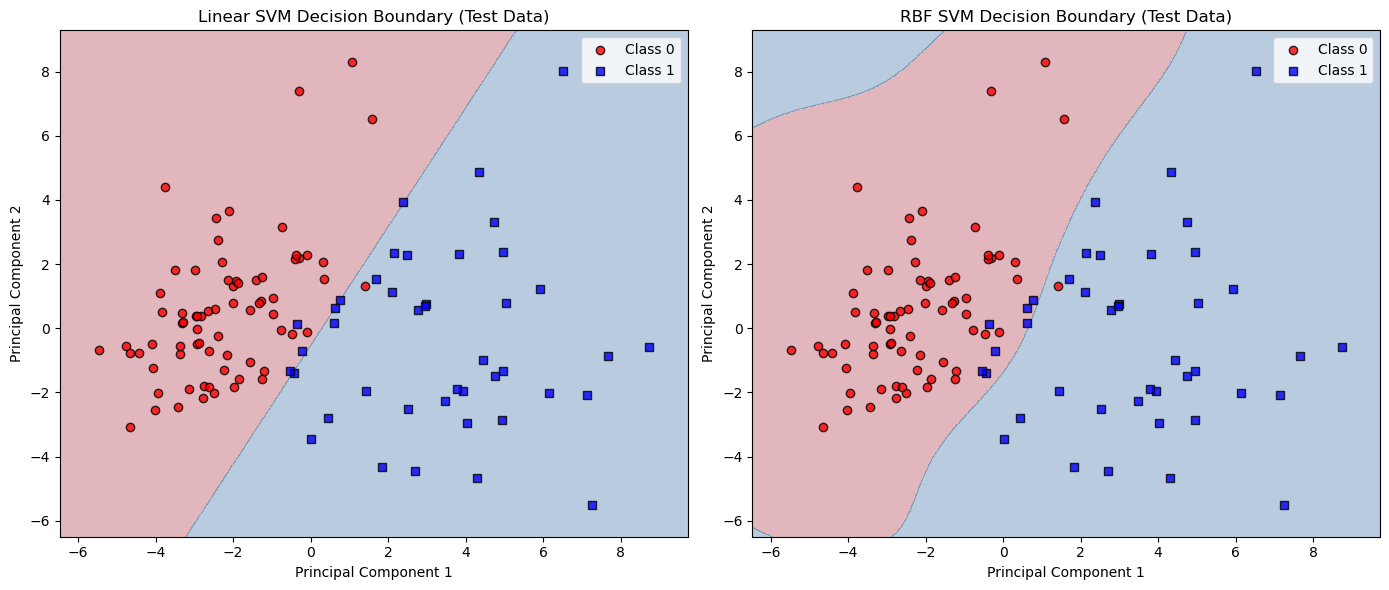


Variance explained by 2 Principal Components: 0.6324


In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# --- 1. Apply PCA to reduce to 2 components ---

# We fit PCA on the entire scaled dataset (X_scaled) to get the best representation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Now, split the PCA-transformed data back into training and testing sets
# We use the same split indices from the initial train_test_split for consistency
X_train_pca = X_pca[y_train.index]
X_test_pca = X_pca[y_test.index]
y_train_pca = y_train # Targets remain the same
y_test_pca = y_test

# --- 2. Train new SVMs on the 2D PCA data ---

# Linear Kernel
linear_svc_pca = SVC(kernel='linear', C=1.0, random_state=42)
linear_svc_pca.fit(X_train_pca, y_train_pca)

# RBF Kernel
rbf_svc_pca = SVC(kernel='rbf', gamma=0.1, C=1.0, random_state=42)
rbf_svc_pca.fit(X_train_pca, y_train_pca)

# --- 3. Visualization Function ---

def plot_decision_boundary(X, y, classifier, title):
    # Setup marker generator and color map
    markers = ('o', 's')
    colors = ('red', 'blue')
    cmap = plt.cm.RdBu

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                         np.arange(x2_min, x2_max, 0.02))
    
    # Predict the class for each point in the mesh
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f'Class {cl}',
                    edgecolor='black')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')

# --- 4. Generate Plots ---

plt.figure(figsize=(14, 6))

# Plot 1: Linear SVM Decision Boundary
plt.subplot(1, 2, 1)
plot_decision_boundary(X_test_pca, y_test_pca, linear_svc_pca, 
                       'Linear SVM Decision Boundary (Test Data)')

# Plot 2: RBF SVM Decision Boundary
plt.subplot(1, 2, 2)
plot_decision_boundary(X_test_pca, y_test_pca, rbf_svc_pca, 
                       'RBF SVM Decision Boundary (Test Data)')

plt.tight_layout()
plt.show()

# Print the explained variance by the 2 components
print(f"\nVariance explained by 2 Principal Components: {np.sum(pca.explained_variance_ratio_):.4f}")

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 1. Define the Parameter Grid 
# We will test various values for C and gamma across orders of magnitude.

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1], # Kernel coefficient gamma
    'kernel': ['rbf'] # Specify the kernel
}

# 2. Initialize GridSearchCV 
# We use a standard 5-fold cross-validation (cv=5).
# scoring='accuracy' tells the grid search what metric to optimize.

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, # 5-fold cross-validation
    verbose=3, # Shows progress messages
    n_jobs=-1 # Use all available CPU cores
)

# 3. Perform Grid Search on the Training Data
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# 4. Analyze Results

print("\n--- Grid Search Results ---")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
print("Best parameters found on training data:")
print(grid_search.best_params_)

# 5. Final Evaluation on Test Set

# Get the best estimator found by the grid search
best_svc = grid_search.best_estimator_

# Predict on the held-out test set
y_pred_best = best_svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_best)

print("\n--- Final Model Performance ---")
print(f"Test Set Accuracy (Tuned RBF SVM): {test_accuracy:.4f}")
print(classification_report(y_test, y_pred_best))

Starting Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- Grid Search Results ---
Best cross-validation accuracy: 0.9758
Best parameters found on training data:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

--- Final Model Performance ---
Test Set Accuracy (Tuned RBF SVM): 0.9561
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



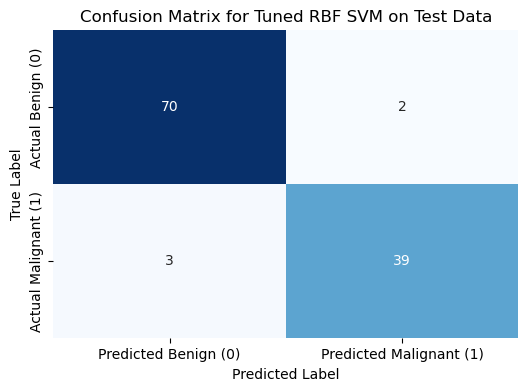


--- Interpretation of Confusion Matrix ---
Top-Left (True Negatives - TN): Correctly predicted Benign.
Top-Right (False Positives - FP): Actually Benign, but predicted Malignant (Type I error).
Bottom-Left (False Negatives - FN): Actually Malignant, but predicted Benign (Type II error).
Bottom-Right (True Positives - TP): Correctly predicted Malignant.

Overall Test Accuracy: 0.9561


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# 2. Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Benign (0)', 'Predicted Malignant (1)'],
            yticklabels=['Actual Benign (0)', 'Actual Malignant (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned RBF SVM on Test Data')
plt.show()

print("\n--- Interpretation of Confusion Matrix ---")
print("Top-Left (True Negatives - TN): Correctly predicted Benign.")
print("Top-Right (False Positives - FP): Actually Benign, but predicted Malignant (Type I error).")
print("Bottom-Left (False Negatives - FN): Actually Malignant, but predicted Benign (Type II error).")
print("Bottom-Right (True Positives - TP): Correctly predicted Malignant.")
print(f"\nOverall Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")